In [1]:
import torch, os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from joblib import dump, load
from ProjectDict import *

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
# device = 'dml' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
print(torch.version.hip)

device: cuda
None


In [2]:
rpath = os.path.join("inspected_data")
theme = laughing_man # laughing_man | wonder_boy
theme_en = laughing_man_en # laughing_man_en | wonder_boy_en
model_type = model_types.base
df = pd.read_csv(os.path.join(rpath, f"{theme}_inspected.csv"),)
embeddings = torch.load(f"cache/{theme_en}_embeddings_{model_type}.pt")

In [3]:
df

,source,nickname,date,title,text,href
0,dc,ㅇㅇ,2023.01.11 00:36:37,ㅃ 어제 마리앙이랑 웃남 영화 관람일이었는데 까먹고 안갔어 휴..,\n\n나 어제 간만에 쉬는날이라 두 탕 하려고 마리앙 웃남 예매해 놨었거든?\n근...,https://gall.dcinside.com/mini/board/view/?id=...
1,dc,ㅇㅇ,2023.01.10 22:04:09,ㅃㅃ웃남cgv 머글 많더라,\n\n난 뮤덕들만 이런 영화 찾아올줄 알았는데 커플도 많고 가족단위도 많더라\n그...,https://gall.dcinside.com/mini/board/view/?id=...
2,dc,ㅇㅇ,2023.01.10 16:14:45,베토벤 넘버 더 없나,\n\n웃남때는 넘버 처음듣고 이거다 하는게 몇개 있었는데 이번꺼는 뭔가 듣자마자 ...,https://gall.dcinside.com/mini/board/view/?id=...
3,dc,ㅇㅇ,2023.01.09 23:07:07,"CGV 웃남 후기(스포,불호 있음)",\n\n웃남 삼연만 본사고 초연 가든파티가 궁금해서 봤는데...초연의 문제라기보다는...,https://gall.dcinside.com/mini/board/view/?id=...
4,dc,ㅇㅇ,2023.01.09 22:29:33,(끌올) 한뮤어 웃남 불판,\n\nhttps://m.dcinside.com/mini/theatergoing/5...,https://gall.dcinside.com/mini/board/view/?id=...
...,...,...,...,...,...,...
6148,twitter,dolphinwhale_,2022-11-01 07:14:08+00:00,NaN,220814 웃는남자 https://t.co/4vFw7BMFK6,https://twitter.com/twitter/status/15873422080...
6149,twitter,rlehd7679,2022-11-01 04:30:18+00:00,NaN,#웃는남자\n네일식스_보노보노 다젖음 작업실 \n💟#조건만남#애인대행 #여공남수#섹...,https://twitter.com/twitter/status/15873009788...
6150,twitter,gunhyun0429,2022-11-01 03:13:54+00:00,NaN,RT @gkflqy: 애기야혹시비와....? 깨자마자 저벅저벅 걸어와서 여친 껴안고...,https://twitter.com/twitter/status/15872817520...
6151,twitter,kjy2429812,2022-11-01 01:58:24+00:00,NaN,#웃는남자\n송파구가족센터 오늘도못자고있다😑😑 온아 웰릭스 \nnull https:...,https://twitter.com/twitter/status/15872627514...


In [4]:
print(embeddings.shape)
df_em = pd.DataFrame(embeddings.to("cpu"))

torch.Size([6153, 768])


In [5]:
folded_file_path = f"cache/{theme}_{model_type}_folded"
if os.path.exists(folded_file_path):
    folded_np = np.load(folded_file_path)
else:
    folded_np = TSNE(n_components=2).fit_transform(df_em)
    np.save(folded_file_path, folded_np)
folded = torch.tensor(folded_np)

Silhouette score: 0.818
Silhouette score: 0.800
Silhouette score: 0.733
Silhouette score: 0.698
Silhouette score: 0.677
Silhouette score: 0.652
Silhouette score: 0.641
Silhouette score: 0.623
Silhouette score: 0.619


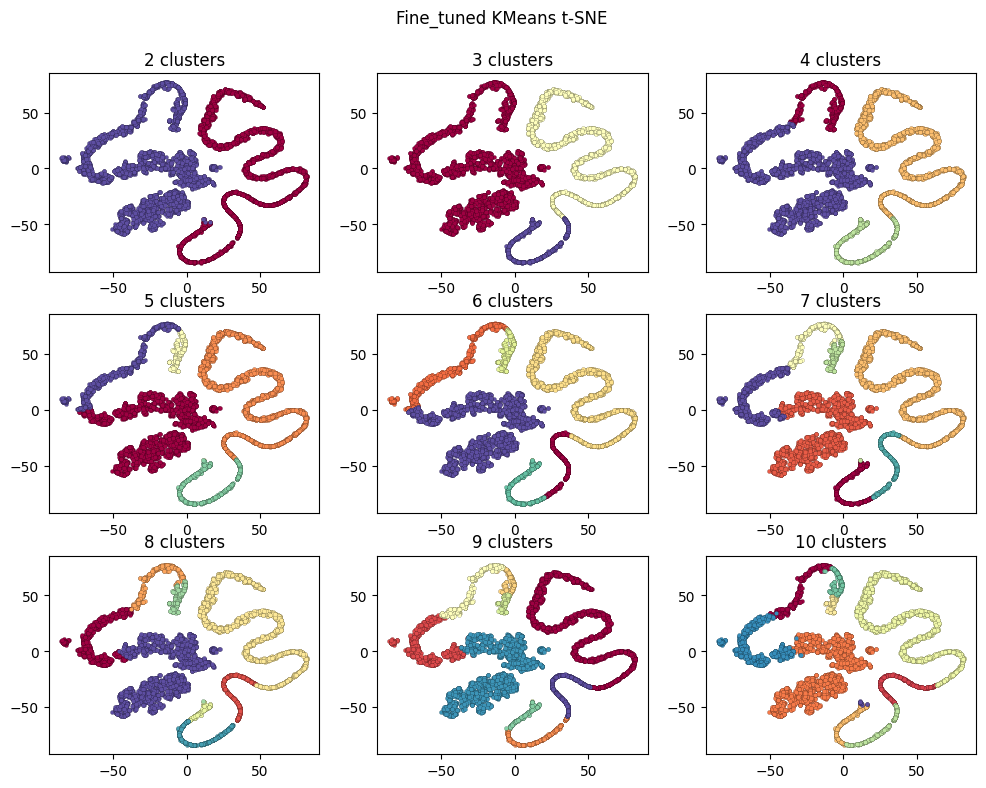

In [6]:
#reference https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

nested_labels = []
silhouettes = []
silhouettes_mean = []
ch_indexes = []

row, column = 3, 3
fig, axes = plt.subplots(row, column)
fig.set_size_inches(10, 8)
fig.suptitle(f"{model_type.capitalize()} KMeans t-SNE")
fig.tight_layout()
fig.subplots_adjust(top=0.9)

x = range(2, 11)
for i, k in enumerate(x):
    model_file_path = f"clustering/{theme}_{model_type.replace('_', '-').capitalize()}_KMeans_{k}.joblib"
    if os.path.exists(model_file_path):
        model = load(model_file_path)
    else:
        model = KMeans(n_clusters=k)
        model.fit(df_em)
        dump(model, model_file_path)
    labels = model.labels_

    nested_labels.append(model.labels_)
    silhouettes.append(silhouette_samples(df_em, labels))
    silhouettes_mean.append(silhouette_score(df_em, labels))
    ch_indexes.append(calinski_harabasz_score(df_em, labels))
    ax = axes[i//column][i%column]

    unique_labels = set(range(k))

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for label, col in zip(unique_labels, colors):
        class_member_mask = labels == label

        xy = folded[class_member_mask].cpu()
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=3,
            markeredgewidth=0.1,
        )

    ax.set_title(f"{k} clusters")
    print(f"Silhouette score: {silhouettes_mean[-1]:0.3f}")

# plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()
    

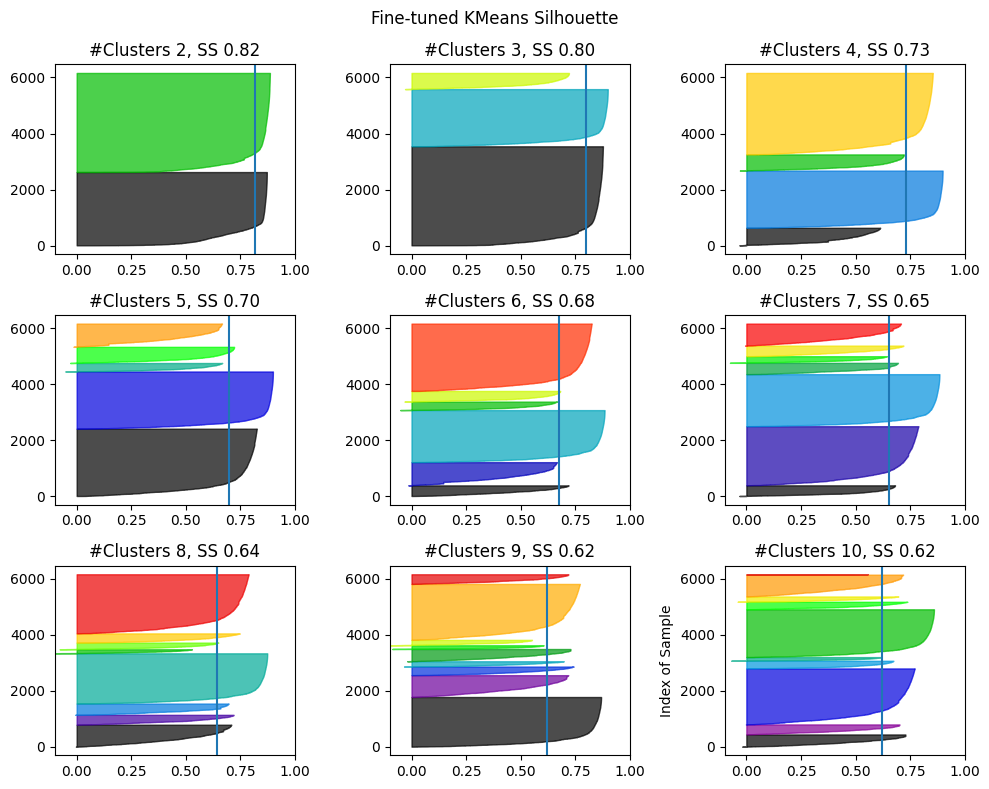

In [7]:
#reference https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

fig, axes = plt.subplots(3, 3)
fig.suptitle(f"{model_type.replace('_', '-').capitalize()} KMeans Silhouette")
fig.set_size_inches(10, 8)

for i, k in enumerate(x):
    labels = nested_labels[i]
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    ax = axes[i//3][i%3]

    ax.axvline(x=silhouettes_mean[i], label=["Sihouette Score"])
    ax.set_xlim(-0.1, 1)
    ax.set_title(f"#Clusters {k}, SS {silhouettes_mean[i]:0.2f}")
    
    y_lower = 10
    for j in range(n_clusters_):
        jth_cluster_silhouette_values = silhouettes[i][nested_labels[i] == j]
        jth_cluster_silhouette_values.sort()

        y_upper = y_lower + jth_cluster_silhouette_values.shape[0]
        color = cm.nipy_spectral(float(j)/n_clusters_)
        ax.fill_betweenx(np.arange(y_lower,y_upper),0,jth_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper


plt.ylabel("Index of Sample")
fig.tight_layout()
plt.show()

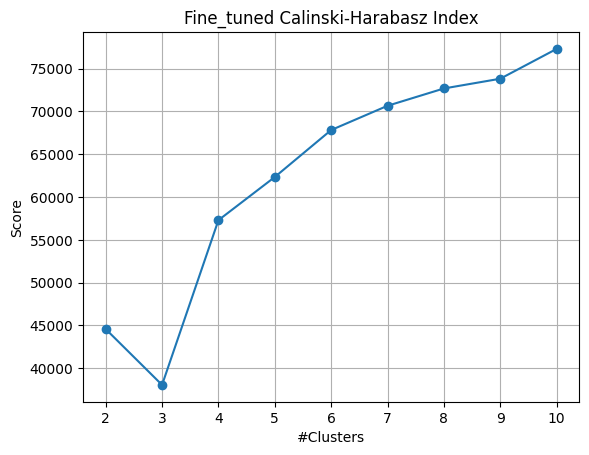

In [8]:
plt.plot(x, ch_indexes, '-o')
plt.xlabel("#Clusters")
plt.ylabel("Score")
plt.title(f"{model_type.capitalize()} Calinski-Harabasz Index")
plt.grid()
plt.show()

Estimated number of clusters: 38, Estimated number of noise points: 3780, Silhouette Score: -0.32045728
Estimated number of clusters: 11, Estimated number of noise points: 722, Silhouette Score: 0.033676583
Estimated number of clusters: 3, Estimated number of noise points: 357, Silhouette Score: 0.6425663
Estimated number of clusters: 4, Estimated number of noise points: 255, Silhouette Score: 0.6682314
Estimated number of clusters: 4, Estimated number of noise points: 202, Silhouette Score: 0.6078706
Estimated number of clusters: 5, Estimated number of noise points: 149, Silhouette Score: 0.61670905
Estimated number of clusters: 3, Estimated number of noise points: 124, Silhouette Score: 0.7045019
Estimated number of clusters: 2, Estimated number of noise points: 106, Silhouette Score: 0.72100204
Estimated number of clusters: 2, Estimated number of noise points: 92, Silhouette Score: 0.72433645


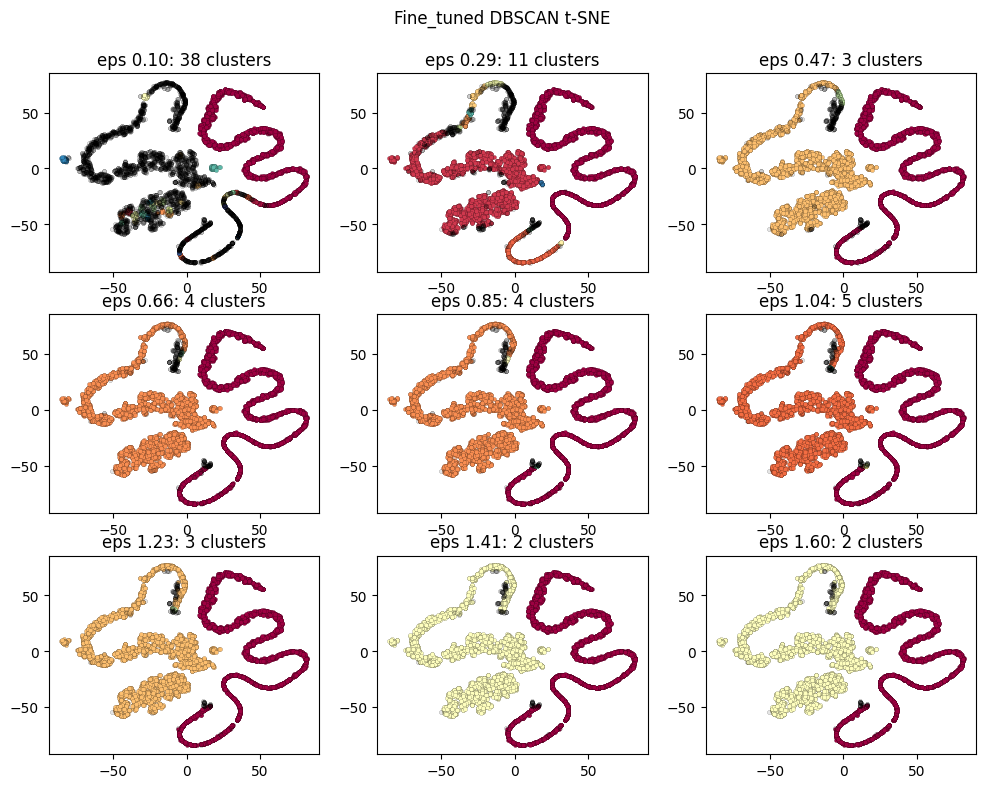

In [9]:
#reference https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

row, column = 3, 3
fig, axes = plt.subplots(row, column)
fig.set_size_inches(10, 8)
fig.suptitle(f"{model_type.capitalize()} DBSCAN t-SNE")
fig.tight_layout()
fig.subplots_adjust(top=.9)

nested_labels = []
clusters = []
silhouettes = []
silhouettes_mean = []
ch_indexes = []

eps_range = np.linspace(0.1, 1.6, row * column)

for i, eps in enumerate(eps_range):
    
    model_file_path = f"clustering/{theme}_{model_type}_DBSCAN_{eps}.joblib"
    if os.path.exists(model_file_path):
        db = load(model_file_path)
    else:
        db = DBSCAN(eps=eps, min_samples=10) 
        db.fit(df_em)
        dump(db, model_file_path)
        
    labels = db.labels_
    nested_labels.append(labels)
    ax = axes[i//column][i%column]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    clusters.append(n_clusters_)
    if n_clusters_ == 1: continue

    print("Estimated number of clusters: %d" % n_clusters_, end = ", ")
    print("Estimated number of noise points: %d" % n_noise_, end = ", Silhouette Score: ")

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 0.1]

        class_member_mask = labels == k

        xy = folded[class_member_mask & core_samples_mask].cpu()
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=3,
            markeredgewidth=0.1,
        )

        xy = folded[class_member_mask & ~core_samples_mask].cpu()
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=3,
            markeredgewidth=0.1,
        )

    ax.set_title(f"eps {eps:0.2f}: {n_clusters_} clusters")

    silhouettes.append(silhouette_samples(df_em, labels))
    silhouettes_mean.append(silhouette_score(df_em, labels))
    ch_indexes.append(calinski_harabasz_score(df_em, labels))
    print(silhouette_score(df_em, labels))

# plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

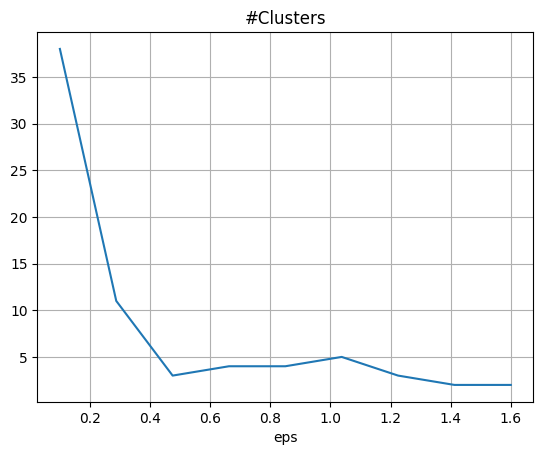

In [10]:
plt.plot(eps_range, clusters)
plt.title("#Clusters")
plt.xlabel("eps")
plt.grid()
plt.show()

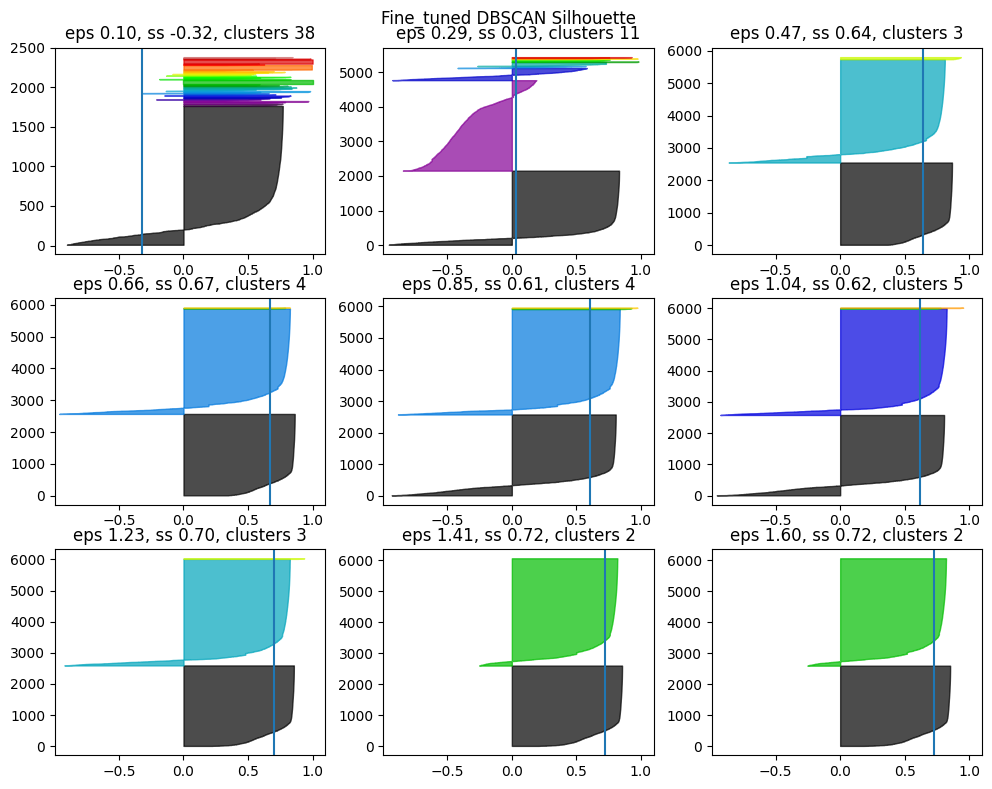

In [11]:
#reference https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
fig, axes = plt.subplots(row, column)
fig.suptitle(f"{model_type.capitalize()} DBSCAN Silhouette")
fig.set_size_inches(10, 8)
fig.tight_layout()

x_min, x_max = min(min(SS) for SS in silhouettes), max(max(SS) for SS in silhouettes)

for i, eps in enumerate(eps_range):
    labels = nested_labels[i]
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    ax = axes[i//row][i%column]
    try:
        ax.set_title(f"eps {eps:0.2f}, ss {silhouettes_mean[i]:0.2f}, clusters {n_clusters_}")
    except IndexError:
        continue
    ax.set_xlim(x_min, x_max * 1.1)
    
    ax.axvline(x=silhouettes_mean[i])
    y_lower = 10
    
    for j in range(n_clusters_):
        jth_cluster_silhouette_values = silhouettes[i][nested_labels[i] == j]
        jth_cluster_silhouette_values.sort()

        y_upper = y_lower + jth_cluster_silhouette_values.shape[0]
        color = cm.nipy_spectral(float(j)/n_clusters_)
        ax.fill_betweenx(np.arange(y_lower,y_upper),0,jth_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper


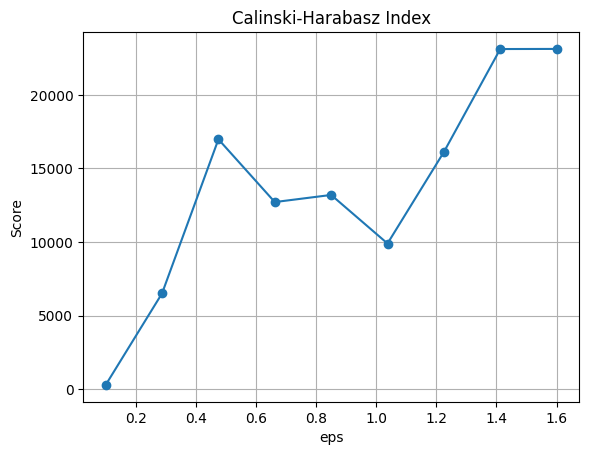

In [12]:
plt.plot(eps_range[:len(ch_indexes)], ch_indexes, '-o')
plt.xlabel("eps")
plt.ylabel("Score")
plt.grid()
plt.title("Calinski-Harabasz Index")
plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 88
Estimated number of clusters: 2
Estimated number of noise points: 94
Estimated number of clusters: 2
Estimated number of noise points: 94
Estimated number of clusters: 2
Estimated number of noise points: 96
Estimated number of clusters: 2
Estimated number of noise points: 99
Estimated number of clusters: 2
Estimated number of noise points: 103
Estimated number of clusters: 2
Estimated number of noise points: 108
Estimated number of clusters: 2
Estimated number of noise points: 110
Estimated number of clusters: 2
Estimated number of noise points: 110


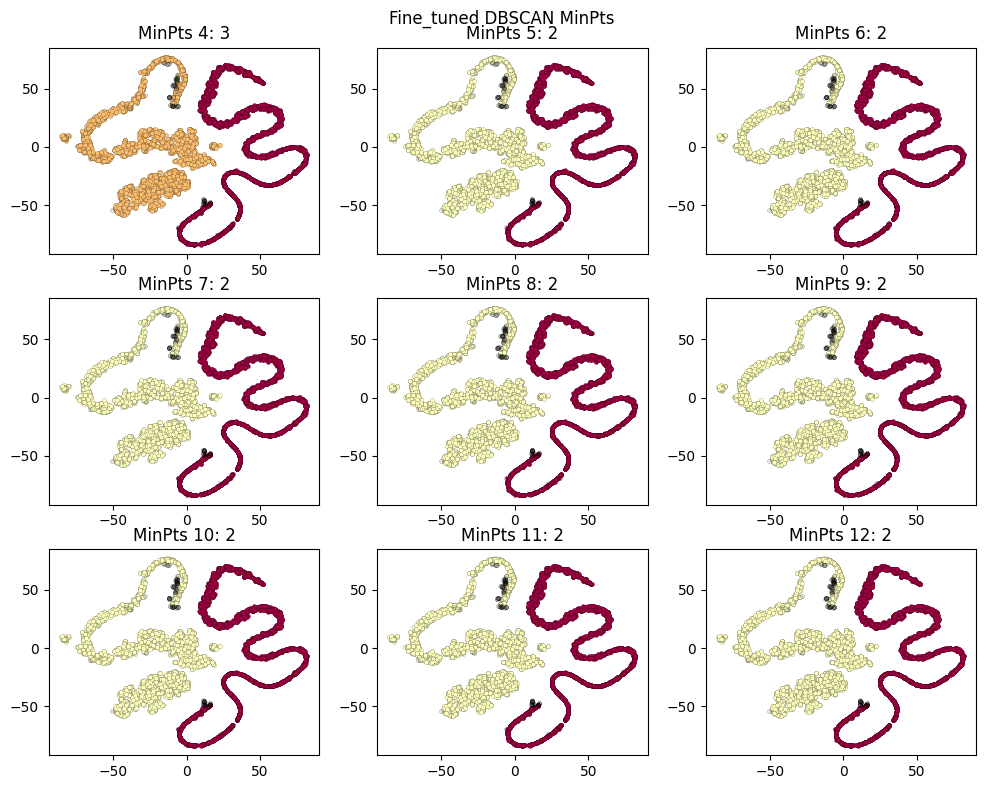

In [13]:
#reference https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
rows, columns = 3, 3
fig, axes = plt.subplots(rows, columns)
fig.set_size_inches(10, 8)
fig.suptitle(f"{model_type.capitalize()} DBSCAN MinPts")
fig.tight_layout()

clusters = []

for i, min_pts in enumerate(np.linspace(4, 12, rows*columns, dtype=int)):
    model = DBSCAN(eps=1.4, min_samples=min_pts)
    db = model.fit(df_em)
    labels = db.labels_
    axe = axes[i//columns][i%columns]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 0.1]

        class_member_mask = labels == k

        xy = folded[class_member_mask & core_samples_mask].cpu()
        axe.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=3,
            markeredgewidth=0.1,
        )

        xy = folded[class_member_mask & ~core_samples_mask].cpu()
        axe.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=3,
            markeredgewidth=0.1,
        )

    axe.set_title(f"MinPts {min_pts}: {n_clusters_}")
    clusters.append(n_clusters_)

# plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()